In [191]:
import awkward as ak
import pathlib
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#from codes.plotting import plot_prettier 
#plot_prettier()

In [192]:
#data = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\ntup_tracks.json"))
data1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\makeMuonPlots.json"))

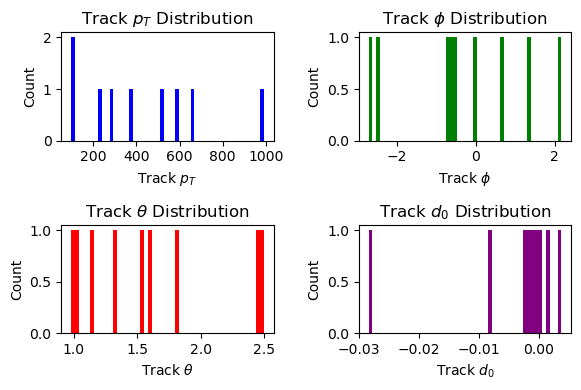

In [194]:
# Extract the required arrays from the data
track_pt = data['track_pt']
track_phi = data['track_phi']
track_theta = data['track_theta']
track_d0 = data['track_d0']
track_z0 = data['track_z0']
track_chi2 = data['track_chi2']
track_ndof = data['track_ndof']

# Create histograms
plt.figure(figsize=(6, 4))

# Histogram for track pt
plt.subplot(2, 2, 1)
plt.hist(ak.flatten(track_pt), bins=50, color='blue')
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution')

# Histogram for track phi
plt.subplot(2, 2, 2)
plt.hist(ak.flatten(track_phi), bins=50, color='green')
plt.xlabel('Track $\\phi$')
plt.ylabel('Count')
plt.title('Track $\\phi$ Distribution')

# Histogram for track theta
plt.subplot(2, 2, 3)
plt.hist(ak.flatten(track_theta), bins=50, color='red')
plt.xlabel('Track $\\theta$')
plt.ylabel('Count')
plt.title('Track $\\theta$ Distribution')

# Histogram for track d0
plt.subplot(2, 2, 4)
plt.hist(ak.flatten(track_d0), bins=50, color='purple')
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title('Track $d_0$ Distribution')

# Adjust subplot spacing
plt.tight_layout()

# Display the histograms
plt.show()


In [115]:
data

<Record {truth_pt: [[525], ...], ...} type='{truth_pt: var * var * float64,...'>

In [193]:
data1

<Record {mcp_pt: [[198], ...], ...} type='{mcp_pt: var * var * float64, mcp...'>

In [243]:
mcp_pt = data1['mcp_pt']
mcp_eta = data1['mcp_eta']
mcp_phi = data1['mcp_phi']
pfo_pt = data1['pfo_pt']
pfo_eta = data1['pfo_eta']
pfo_phi = data1['pfo_phi']
pfo_mu_pt = data1['pfo_mu_pt']
pfo_mu_eta = data1['pfo_mu_eta']
pfo_mu_phi = data1['pfo_mu_phi']
mcp_mu_pt = data1['mcp_mu_pt']
mcp_mu_eta = data1['mcp_mu_eta']
mcp_mu_phi = data1['mcp_mu_phi']
mcp_mu_match_pt = data1['mcp_mu_match_pt']
mcp_mu_match_eta = data1['mcp_mu_match_eta']
mcp_mu_match_phi = data1['mcp_mu_match_phi']
d_mu_dpt = data1['d_mu_dpt']
d_mu_drelpt = data1['d_mu_drelpt']
d_mu_dphi = data1['d_mu_dphi']
d_mu_deta = data1['d_mu_deta']
nhits = data1['nhits']
pt_res_hits = data1['pt_res_hits']
# pt_res_vs_eta = data1['pt_res_vs_eta']
# pt_res_vs_pt = data1['pt_res_vs_pt']
# d0_res_vs_pt = data1['d0_res_vs_pt']
# d0_res_vs_eta = data1['d0_res_vs_eta']
# z0_res_vs_pt = data1['z0_res_vs_pt']
# z0_res_vs_eta = data1['z0_res_vs_eta']
# d0_res = data1['d0_res']
# z0_res = data1['z0_res']
pt_res = data1['pt_res'] 
pt_match = data1['pt_match']
eta_match = data1['eta_match']
ndf = data1['ndf']
chi2 = data1['chi2']
d0_res_match = data1['d0_res_match']
z0_res_match = data1['z0_res_match']
h2d_relpt = data1['h_2d_relpt']

In [7]:
theta_match = 2 * np.arctan(np.exp(-eta_match))
print(eta_match)
print(theta_match)
#theta_match = [[math.degrees(angle) for angle in sublist] for sublist in theta_match]
theta_match = np.degrees(theta_match)
print(theta_match)

[[0.544], [1.31], [0.363], [0.121], ..., [1.46], [-0.439], [-1.36], [-1.5]]
[[1.05], [0.528], [1.22], [1.45], [1.31], ..., [0.455], [2], [2.64], [2.7]]
[[60.3], [30.2], [69.7], [83.1], [75.1], ..., [26.1], [114], [151], [155]]


### Binning impact parameters by $p_T$

In [185]:
pT_ranges = [1,100, 500, np.inf]  # The last value should be np.inf to cover 200+ GeV

# Define relaxed cutoffs for lower pT ranges
pT_d0_cutoffs = [0.8, 0.7, 0.6, 0.5]  # Example: 1-5 GeV, 5-50 GeV, 50-200 GeV
pT_z0_cutoffs = [1.8, 1.7, 1.6, 1.5]  # Example: 1-5 GeV, 5-50 GeV, 50-200 GeV

# Initialize the target arrays with NaN values to preserve the dtype
d0_masked = []
z0_masked = []
pt_res_masked = []
pt_masked_d0 = []
pt_masked_z0 = []
theta_masked_d0 = []
theta_masked_z0 = []

# Create subsets of data for different pT ranges and apply resolution cutoffs
for i in range(len(pT_ranges) - 1):
    pT_min = pT_ranges[i]
    pT_max = pT_ranges[i + 1]

    # Create a mask for the current pT range
    mask = np.array([pT_min <= x[0] < pT_max for x in pt_match])  

    # Apply resolution cutoffs for d0 and z0
    d0_cutoff = np.array([x[0] < pT_d0_cutoffs[i] for x in d0_res_match])
    z0_cutoff = np.array([x[0] < pT_z0_cutoffs[i] for x in z0_res_match])
    theta_cutoff = np.array([70 <= x[0] < 110 for x in theta_match])
    d0_mask = mask & d0_cutoff #& theta_cutoff
    z0_mask = mask & z0_cutoff & theta_cutoff
    # Create subsets of data for the current pT range and apply the resolution cutoffs
    #pT_subset = pt_match[mask]
    d0_masked.append(d0_res_match[d0_mask])
    z0_masked.append(z0_res_match[z0_mask])
    dpT_pt = []
    for x, y in zip(pt_res[d0_mask], pt_match[d0_mask]):
        dpT_pt.append([x[0] / y[0]])
    pt_res_masked.append(dpT_pt)  
    pt_masked_d0.append(pt_match[d0_mask])
    pt_masked_z0.append(pt_match[z0_mask])
    theta_masked_d0.append(theta_match[d0_mask])
    theta_masked_z0.append(theta_match[z0_mask])
    print('# of points in pT range', pT_min, '-', pT_max, '=', len(theta_match[d0_mask]))
print(pt_res_masked)
print(theta_masked_d0)
# print(len(d0_masked))
# print(len(theta_masked_d0))
# for i in range(len(d0_masked)):
#     print(len(d0_masked[i]))
#     print(len(theta_masked_d0[i]))

# of points in pT range 1 - 5 = 6
# of points in pT range 5 - 50 = 61
# of points in pT range 50 - 200 = 226
# of points in pT range 200 - inf = 615
[[[-0.001068046605391869], [0.0032041255556874457], [0.0013221317203884408], [0.0031551344693428072], [-0.0020384413179971874], [0.0007104517618979638]], [[-9.754478972651423e-05], [0.0003022489352849985], [-0.06843839934708404], [-2.0166027525689396e-05], [-5.195440027578985e-06], [-5.269183955631096e-05], [4.172335932701118e-05], [-0.002194350900790534], [0.000467605928157807], [0.00019868092928916302], [5.629144375839165e-05], [3.1591814487861825e-07], [-0.14466809360570607], [0.00046154352673090994], [0.00020450611384438685], [7.25927387699223e-05], [0.0003709310892113143], [-0.0002927781719188397], [0.0008198036589335095], [0.00012107360756302737], [0.0011418419210179605], [2.6384614047227806e-05], [0.0001805074672320846], [2.0102295385852786e-05], [5.225269695736347e-05], [7.146250338100561e-05], [0.00010783776665489464], [2.53213266

In [175]:
print(pt_match)

[[198], [247], [393], [531], [352], ..., [260], [11.1], [14], [78.9], [198]]


### Plotting Functions

In [248]:
# Function for creating a Gaussian fit
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2)

def fit_gaussian(slice_data, bins=np.linspace(-0.5, 0.5, 100), mean = 0, rms = 0.01):
    if mean is None:
        rms = np.mean(slice_data)
    if mean is None:
        rms = np.sqrt(np.mean(np.square(slice_data - mean)))
    counts, bin_edges = np.histogram(slice_data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), mean, rms])
    return popt, pcov, bin_centers

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT for multiple pT bins

def plotrms_multi(datax, datay, bins, labels=None, xlabel = '', ylabel='', title=''):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    for j in range(len(datay)):
        data_flatx = np.array(np.ravel(datax[j])).T
        data_flaty = np.array(np.ravel(datay[j])).T
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
        rms_values = []
        sem_values = []
        for i in range(bins):
            slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
            gaussian_fit = True
            try:
                # Fit a Gaussian to the slice data using the fit_gaussian function
                popt, pcov, bin_centers = fit_gaussian(slice_data)
                fitted_mean = popt[1]
                fitted_rms = popt[2]
            except RuntimeError:
                print(f"Could not fit Gaussian for Slice {i}.")
                rms = np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data))))
                rms_values.append(rms)
                #sem_values.append(np.std(x_bin_data, ddof=1) / np.sqrt(len(x_bin_data)))
                gaussian_fit = False
                continue            
            # sem = np.std(slice_data, ddof=1) / np.sqrt(len(slice_data))
            # if np.isnan(sem) or sem == 0:
            #     continue  # Skip bins with zero or NaN standard deviation
            rms_values.append(fitted_rms)
            #sem_values.append(sem)

        ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), fmt='o', markersize=4, label=labels[j])#, linestyle='-')
        #ax.scatter((x_bins[:-1] + x_bins[1:]) / 2, rms_values, label=labels[j])#, linestyle='-')
    # title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    # xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    # ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    ax.set_yscale('log')
    ax.legend()
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT

def plotrms(datax, datay, bins, label="", xlim=None, ylim=None):
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if xlim is not None:
        x_bins = np.linspace(xlim[0], xlim[1], bins + 1)
    else:
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
    
    rms_values = []
    sem_values = []
    
    for i in range(bins):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        print("Bin", i, "has", len(slice_data), "data points")
        
        # Calculate the RMS and mean directly without histogramming and fitting a Gaussian
        actual_mean = np.mean(slice_data)
        actual_rms = np.sqrt(np.mean(np.square(slice_data - actual_mean)))
        try:
            counts, bin_edges = np.histogram(slice_data, bins=100)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), actual_mean, actual_rms])
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            sem_values.append(np.sqrt(pcov[2, 2]))
            rms_values.append(fitted_rms)
        except RuntimeError:
            print(f"Could not fit Gaussian for Slice {i}.")
            rms_values.append(actual_rms)
            sem_values.append(np.std(slice_data, ddof=1) / np.sqrt(len(slice_data)))
            continue
        
        #print(f"Iteration {i}, rms_values size: {len(rms_values)}, sem_values size: {len(sem_values)}")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, yerr = sem_values, color = 'darkblue', fmt='o', markersize=4)#, linestyle='-')
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if ylim is not None:
            ax.set_ylim(ylim[0], ylim[1])
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting a 1D histogram and fitting a Gaussian to it

def plotrms_slice(datax, datay, x_bins, bins, title=""):
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T

    for i in range(len(x_bins)-1):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        gaussian_fit = True
        try:
            # Fit a Gaussian to the slice data using the fit_gaussian function
            popt, pcov, bin_centers = fit_gaussian(slice_data, bins)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
        except RuntimeError:
            print(f"Could not fit Gaussian for Slice {i}.")
            gaussian_fit = False
            continue

        # Print the values
        print(f"Slice {i}:", x_bins[i], 'to', x_bins[i + 1])
        #print("Actual Mean:", actual_mean)
        print("Mean from Fit:", fitted_mean)
        #print("Actual RMS:", actual_rms)
        print("Sigma from Fit:", fitted_rms)
        print("------------------------------------")

        # Plot the 1D histogram with the Gaussian fit
        plt.hist(slice_data, bins, alpha=0.5, label=f'Slice {i}')
        if gaussian_fit:
            plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Gaussian Fit')
        plt.xlabel('Data')
        plt.ylabel('Counts')
        plt.title(title+ f' for Slice {i}')
        plt.legend()
        plt.show()

##############################################################################################################################################################################################################################
# 2D Histogram plotting function

def plot2DHistogram(datax, datay, bins=100, norm="log", label="", xlim = None, ylim = None, stats = True):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        #fwhm_value = fwhm(data_flaty, bins = np.linspace(np.min(data_flaty), np.max(data_flaty), bins[1]))
        
        # Create a text box to display statistics
        # stats_text = 'FWHM '+ylabel+f':{fwhm_value:.3f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        # ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)

    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

### Make 1D Histograms and Compute The RMS (also checking to see whether the fitted Gaussian matches expectations)

c:\Users\leoro\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Could not fit Gaussian for Slice 2.
Could not fit Gaussian for Slice 4.
Could not fit Gaussian for Slice 5.
Could not fit Gaussian for Slice 6.
Could not fit Gaussian for Slice 3.
Could not fit Gaussian for Slice 4.


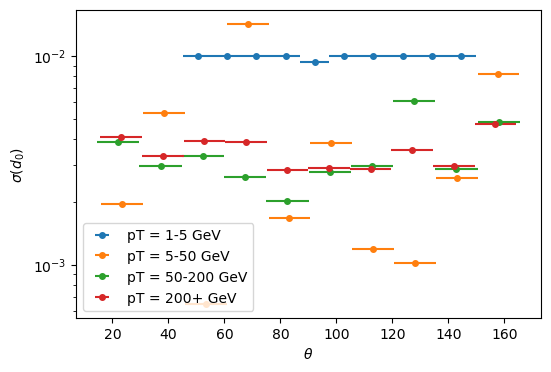

In [249]:
plotrms_multi(theta_masked_d0,d0_masked, bins = 10, labels = ['pT = 1-5 GeV', 'pT = 5-50 GeV', 'pT = 50-200 GeV', 'pT = 200+ GeV'], xlabel = r'$\theta$', ylabel = r'$\sigma(d_0)$ ', title = '')

Slice 0: 0 to 100
Mean from Fit: 0.0006233919088416613
Sigma from Fit: 0.003052085107134286
------------------------------------


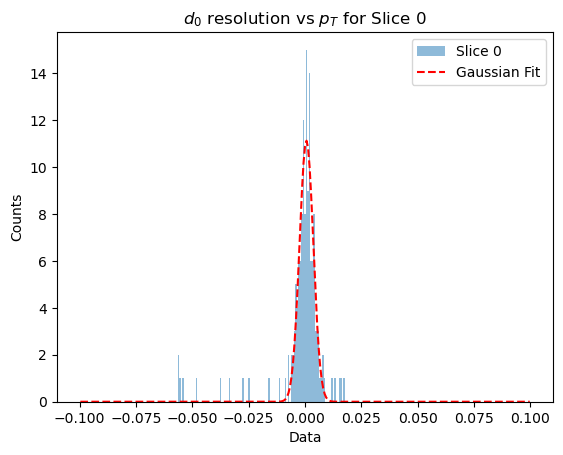

Slice 1: 100 to 200
Mean from Fit: 0.0005875232294499481
Sigma from Fit: 0.0021537372207746986
------------------------------------


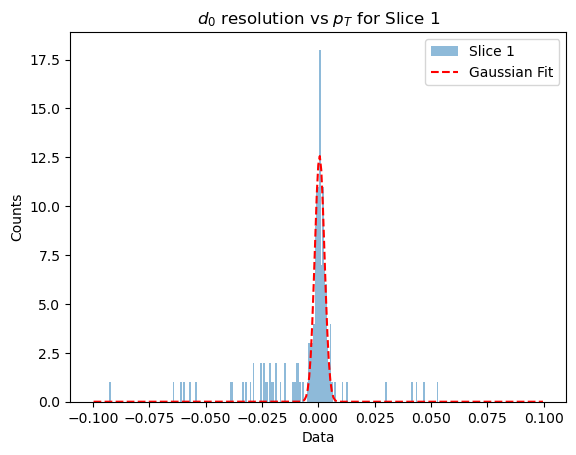

Slice 2: 200 to 400
Mean from Fit: 0.0007940587182192534
Sigma from Fit: 0.0019056815534275844
------------------------------------


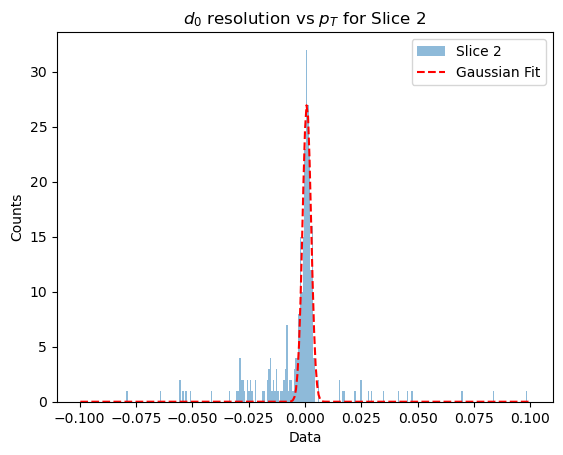

Slice 3: 400 to 600
Mean from Fit: 0.0008531036130087578
Sigma from Fit: 0.0012407795842308228
------------------------------------


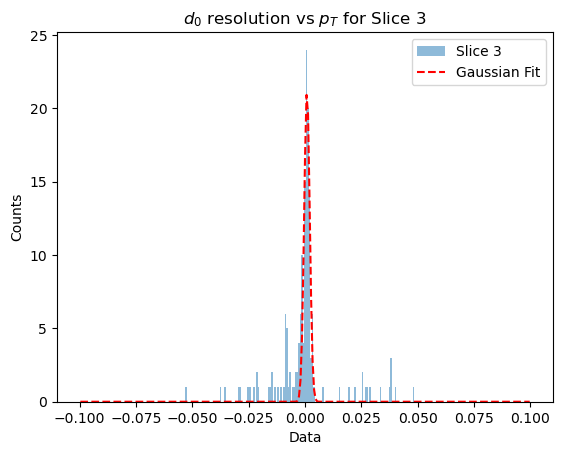

Slice 4: 600 to 1000
Mean from Fit: 0.000308750767151532
Sigma from Fit: 0.0019762202546827748
------------------------------------


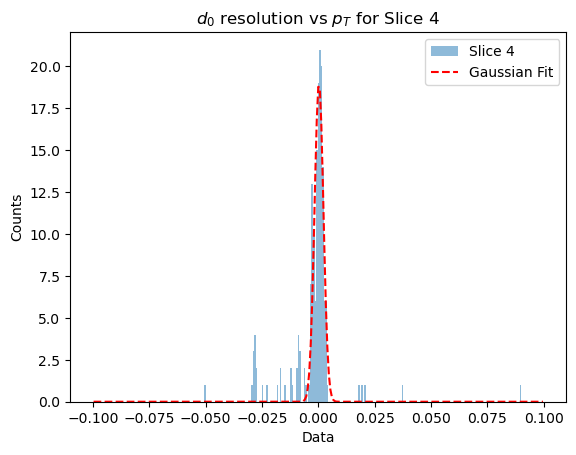

In [244]:
d0_bins = np.linspace(-0.1, 0.1, 300)
pT_bins = np.linspace(-0.5, 0.5, 100)
x_bins = np.array([0, 100, 200, 400, 600, 1000])
d0_title = r'$d_0$ resolution vs $p_T$'
pT_title = r'$p_T$ resolution vs $p_T$'
plotrms_slice(pt_match, d0_res_match, x_bins = x_bins, bins=d0_bins, title=d0_title)

### Plot 2D Hists showing resolution against $p_T$/$\eta$ and then the RMS of them against $\eta$

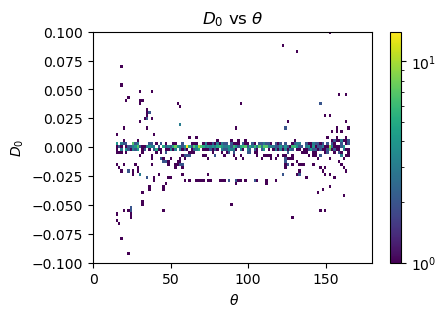

Bin 0 has 182 data points
Bin 1 has 199 data points
Bin 2 has 185 data points
Bin 3 has 179 data points
Bin 4 has 178 data points


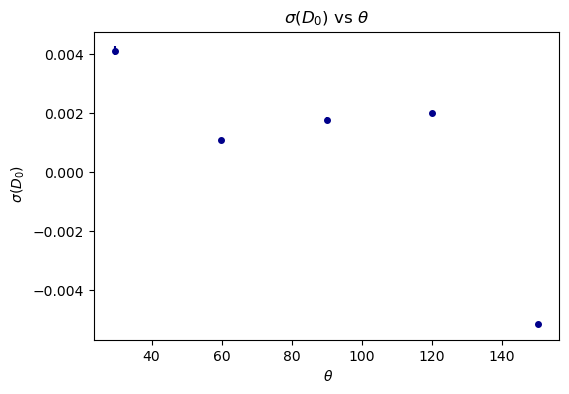

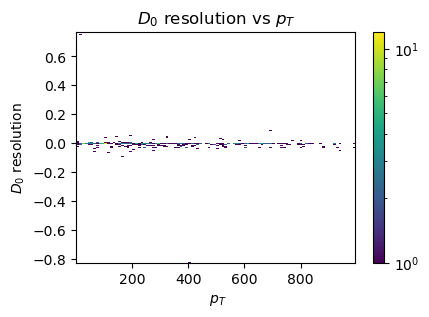

Bin 0 has 49 data points
Bin 1 has 53 data points
Bin 2 has 42 data points
Bin 3 has 54 data points
Bin 4 has 44 data points


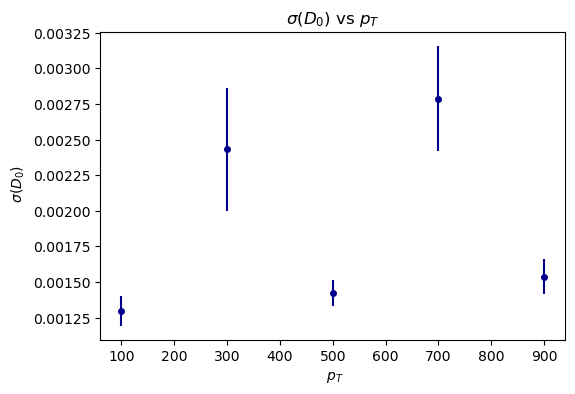

Bin 0 has 115 data points
Bin 1 has 188 data points
Bin 2 has 292 data points
Bin 3 has 210 data points
Bin 4 has 118 data points


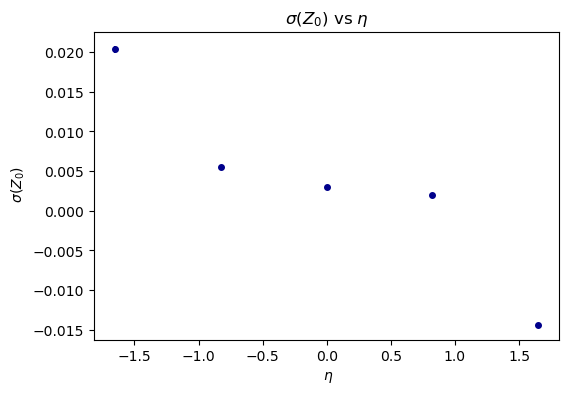

Bin 0 has 298 data points
Bin 1 has 283 data points
Bin 2 has 167 data points
Could not fit Gaussian for Slice 2.
Bin 3 has 117 data points
Bin 4 has 59 data points


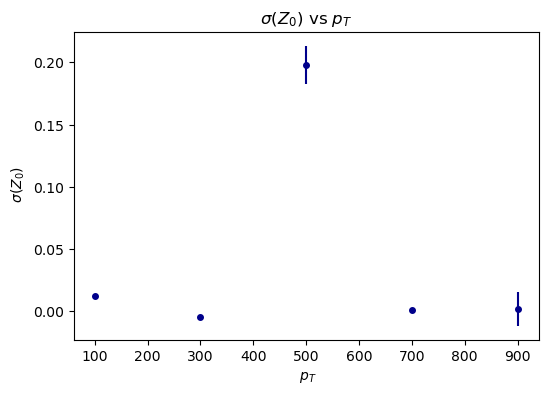

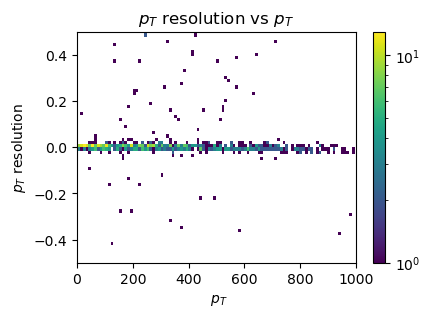

Bin 0 has 298 data points
Bin 1 has 283 data points
Could not fit Gaussian for Slice 1.
Bin 2 has 167 data points
Could not fit Gaussian for Slice 2.
Bin 3 has 117 data points
Bin 4 has 59 data points


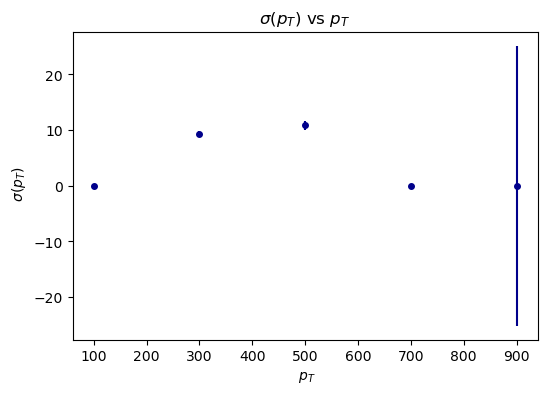

Bin 0 has 115 data points
Bin 1 has 188 data points
Bin 2 has 292 data points
Could not fit Gaussian for Slice 2.
Bin 3 has 210 data points
Could not fit Gaussian for Slice 3.
Bin 4 has 118 data points


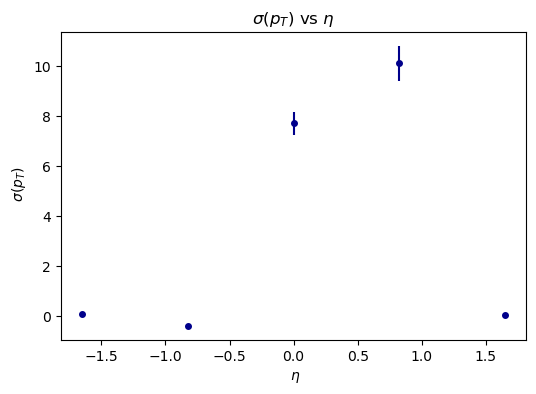

In [213]:
# # Histogram for mcp_eta
# plt.figure(figsize=(6, 3))

# plt.subplot(1, 2, 1)
# plt.hist((mcp_eta), bins=50, color='green')
# plt.xlabel('MCP $\\eta$')
# plt.ylabel('Count')
# plt.title('MCP $\\eta$ Distribution')

# # Histogram for mcp_phi
# plt.subplot(1, 2, 2)
# plt.hist((mcp_phi), bins=50, color='red')
# plt.xlabel('MCP $\\phi$')
# plt.ylabel('Count')
# plt.title('MCP $\\phi$ Distribution')

# # Adjust subplot spacing
# plt.tight_layout()

pt_xlim = [0, 1000]
rms_bins = 5
plot2DHistogram(theta_match, d0_res_match, bins=(100,600), label=r"$D_0$ vs $\theta$; $\theta$;$D_0$", xlim = (0,180), ylim = (-0.1,0.1))
plotrms(theta_match, d0_res_match, bins=rms_bins, label=r"$\sigma(D_0)$ vs $\theta$; $\theta$; $\sigma(D_0)$")
plot2DHistogram(pt_match, d0_res_match, bins=(100,600), label=r"$D_0$ resolution vs $p_T$; $p_T$;$D_0$ resolution")#, xlim = (0,1000), ylim = (-0.1,0.1))
plotrms(pt_match[d0_cutoff & theta_cutoff], d0_res_match[d0_cutoff & theta_cutoff], bins=rms_bins, label=r"$\sigma(D_0)$ vs $p_T$; $p_T$; $\sigma(D_0)$", xlim = pt_xlim)
# plot2DHistogram(eta_match, z0_res_match, bins=(100,1000), label=r"$Z_0$ resolution vs $\eta$; $\eta$;$Z_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
plotrms(eta_match, z0_res_match, bins=rms_bins, label=r"$\sigma(Z_0)$ vs $\eta$; $\eta$; $\sigma(Z_0)$")
# plot2DHistogram(pt_match, z0_res_match, bins=(100,1000), label=r"$Z_0$ resolution vs $p_T$; $p_T$;$Z_0$ resolution", xlim = (0,1000), ylim = (-0.1,0.1))
plotrms(pt_match, z0_res_match, bins=rms_bins, label=r"$\sigma(Z_0)$ vs $p_T$; $p_T$; $\sigma(Z_0)$", xlim = pt_xlim)
plot2DHistogram(pt_match, pt_res, bins=(100,10000), label=r"$p_T$ resolution vs $p_T$; $p_T$;$p_T$ resolution", xlim = (0,1000), ylim = (-0.5,0.5))
plotrms(pt_match, pt_res, bins=rms_bins, label=r"$\sigma(p_T)$ vs $p_T$; $p_T$; $\sigma(p_T)$", xlim = pt_xlim)
# plot2DHistogram(eta_match, pt_res, bins=(100,10000), label=r"$p_T$ resolution vs $\eta$; $\eta$;$p_T$ resolution", xlim = (-3,3), ylim = (-0.5,0.5))
plotrms(eta_match, pt_res, bins=rms_bins, label=r"$\sigma(p_T)$ vs $\eta$; $\eta$; $\sigma(p_T)$")


Text(0.5, 1.0, 'Track $p_T$ Resolution')

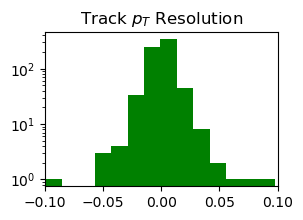

In [139]:
plt.figure(figsize=(3, 2))

plt.hist((np.ravel(pt_res)), bins=10000, color='green')
plt.yscale('log')
plt.xlim(-0.1,0.1)
plt.title('Track $p_T$ Resolution')